# Is Fandango Still Inflating Ratings?
### Investigating Fandango Movie Ratings


In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in this article — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Getting familiar with the data

There are two samples of data, one is the data that was collected prior to Hickney's analysis, and the other one is a sample which was collected afterward. We will start by exploring the two datasets.

* Walt Hickey made the data he analyzed publicly available on GitHub. We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

* One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on GitHub and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from numpy import arange

In [146]:
before = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

In [147]:
before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [148]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


We will isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use.

In [149]:
#Copy will be used to avoid any SettingWithCopyWarning warning.

f_before = before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 
                          'Fandango_Difference']].copy()
f_after = after[['movie', 'year', 'fandango']].copy()
f_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [150]:
f_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


After reading the README.md files of the two repositories, we will see if the two samples are representative for the population we're trying to describe.
The population of interest for our analysis comprises all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to determine if the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — before and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken prior to the analysis, and the other was taken after the analysis. We want to describe the population, so we need to make sure that the samples are representative; otherwise, we should expect a large sampling error and, ultimately, inaccurate conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested in describing. It seems more likely that it isn't, mostly because this sample is subject to temporal trends (e.g., movies in 2015 might have been outstandingly good or bad compared to other years).

The sampling conditions for our other sample were the following (as it can be read in the README.md of the data set's repository):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (it's unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends, and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.



## Changing the Goal of our Analysis

As we concluded that the sampling processes were not random, the resulting samples are very unlikely to be representative of the population we're interested in describing. 

At this point, we have at least two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations on it.

Tweaking our goal seems a much faster choice compared to collecting new data. Also, it's quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time.

With the new goal, we now have two populations that we want to describe and compare with each other:

* All Fandango's ratings for popular movies released in 2015.

* All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

A quick way to check representativity of this sample is to randonmy sample 10 movies from it and then check the nuber of fan ratings on Fandango's website.

In [151]:
f_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Using the random seed as 1 is a good option, as it means we have not played with this value just to get favourable sample for our needs.

We will also check the sample sample which Hicks collected, where it clearly states that there are only movies with at least 30 fan ratings.

In [152]:
(f_before['Fandango_votes'] < 30).sum() # all false values will be counted as 0

0

We will continue wit Hickney's dataset, and isolate only movies  released in 2015. As there is no column with year or date. We will extract it from the movie name from the first column.

In [153]:
f_before['Year'] = f_before['FILM'].str[-5:-1]
f_before.head(3)


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015


Let's examine the frequency distribution for the `'Year'` column and then find the movies released only in 2015.

In [154]:
print(f_before['Year'].value_counts())
f_2015 = f_before[f_before['Year'] == '2015'].copy()
f_2015['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64


2015    129
Name: Year, dtype: int64

We will do the same for the dataset "after".

In [155]:
print(f_after['year'].value_counts())
f_2016 = f_after[f_after['year'] == 2016].copy()
f_2016['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64


2016    191
Name: year, dtype: int64


## Comparing Distribution Shapes for 2015 and 2016

After all these preliminary steps, we can now start analyzing the two samples we isolated before. Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

There are many ways we can go about with our analysis, but let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

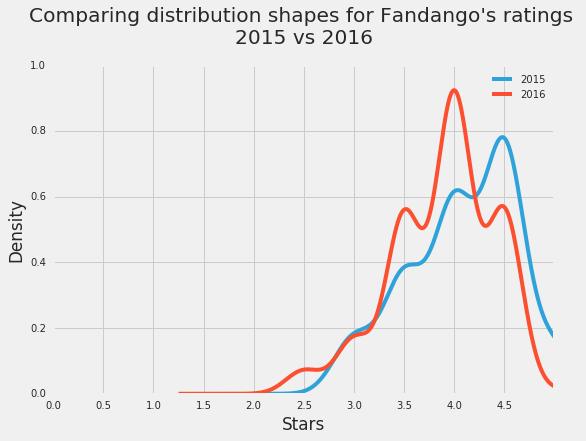

In [156]:
plt.style.use('fivethirtyeight')
f_2015['Fandango_Stars'].plot.kde( label = '2015', legend = True, figsize = (8, 5.5))
f_2016['fandango'].plot.kde(legend = True, label = '2016')
plt.title("Comparing distribution shapes for Fandango's ratings \n2015 vs 2016",
         y = 1.05)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5,.5))
plt.show()

Two interesting trends pop up from the graph above:

* Both distributions are negatively skewed
* The graph for the 2016 is slightly shifted to the left.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.



## Comparing Relative Frequencies

The kernel density plots from the previous screen showed that there's a clear difference between the two distributions. They also provided us with information about the direction of the difference: movies in 2016 were rated slightly lower than those in 2015.

While comparing the distributions with the help of the kernel density plots was a great start, we now need to analyze more granular information. Datasets have different numbers of movies, we normalize the tables and show percentages instead.

In [157]:
print('2015' + '\n' + '---'* 6)
f_2015['Fandango_Stars'].value_counts(normalize = True).sort_index()

2015
------------------


3.0    0.085271
3.5    0.178295
4.0    0.286822
4.5    0.379845
5.0    0.069767
Name: Fandango_Stars, dtype: float64

In [158]:
print('2016' + '\n' + '---' * 6)
f_2016['fandango'].value_counts(normalize = True).sort_index()

2016
------------------


2.5    0.031414
3.0    0.073298
3.5    0.240838
4.0    0.403141
4.5    0.246073
5.0    0.005236
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings, and this challenges the direction of the change we saw on the kernel density plots.



## Determining the Direction of the Change

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

In [159]:
f_2015['Fandango_Stars'].describe()

count    129.000000
mean       4.085271
std        0.538096
min        3.000000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: Fandango_Stars, dtype: float64

In [160]:
summary = pd.DataFrame()

mean_2015 = f_2015['Fandango_Stars'].mean()
median_2015 = f_2015['Fandango_Stars'].median()
mode_2015 = f_2015['Fandango_Stars'].mode()[0]

mean_2016 = f_2016['fandango'].mean()
median_2016 = f_2016['fandango'].median()
mode_2016 = f_2016['fandango'].mode()[0]

summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ('mean', 'median', 'mode')


In [161]:
summary.head()

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


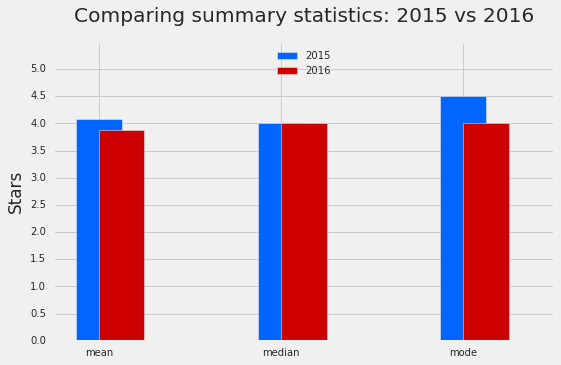

In [162]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = 0.25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', 
                         width = 0.25, rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.05)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,0.5))
plt.ylabel('Stars')
plt.legend(loc = 'upper center')
plt.show()


As seen mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [163]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

## Conclusion

Our analysis showed that there is indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system following Hickey's analysis.